In [1]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")
sys.path.append("/home/yifan/projects/cophi/ContraVis")
import numpy as np

sys.path.append("/home/yifan/projects/deepdebugertool/DLVisDebugger")
# REF_PATH = "/home/yifan/Exp/Noise/0.2/experiment_vis"
# CONFIG_PATH = "/home/yifan/experiments/noise/20"
# TAR_PATH = "/home/yifan/dataset/cleanfornoise10"

# # CLEAN_PATH = "/home/yifan/Exp/Noise/0.2/experiment1"
TAR_PATH = "/home/yifan/dataset/resnet18_init/pairflip/cifar10/0"
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"



ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'vis2'

########## initulize reference data and target data
from AlignVis.DataInit import DataInit
REF_EPOCH = 200
TAR_EPOCH = 200
DEVICE = "cuda:1"
tar_datainit = DataInit(TAR_PATH,TAR_PATH,TAR_EPOCH,DEVICE)
ref_datainit = DataInit(REF_PATH,REF_PATH,REF_EPOCH,DEVICE)

ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from AlignVis.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(18,0.8,0.3,0.05)


from AlignVis_Visualizer.visualizer import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 512.04it/s]


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8632.03it/s]


absolute alignment indicates number: 194 label diff indicates number: 13 confidence diff indicates number: 10 high distance number: 0


(50000, 512) (50000, 512)
Computing decision regions ...
(50000, 512) (50000, 512)
(40000, 512) (40000, 512)


100%|██████████| 200/200 [00:00<00:00, 9745.58it/s]


(50000, 512) (50000, 512)


100%|██████████| 250/250 [00:00<00:00, 8762.96it/s]


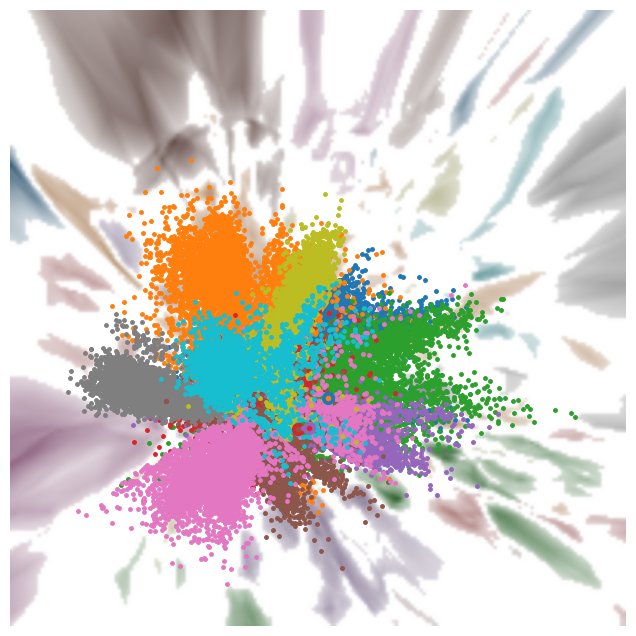

In [2]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")


from visulizer.visualizer_linear import visualizer
vis = visualizer(ref_provider,tar_provider, projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")


vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

In [10]:
import numpy as np
from scipy.linalg import svd

# 假设 data1 和 data2 已经给出
# 例如：
# data1 = np.random.rand(50000, 512)
# data2 = np.random.rand(50000, 512)

def orthogonal_mapping(data1, data2):
    """
    使用Orthogonal Mapping方法将data2映射到data1空间。
    
    :param data1: numpy array, shape (n_samples, n_features)
    :param data2: numpy array, shape (n_samples, n_features)
    :return: data2_mapped: numpy array, 映射后的data2
    """
    # 步骤1: 中心化数据
    data1_centered = data1 - np.mean(data1, axis=0)
    data2_centered = data2 - np.mean(data2, axis=0)

    # 步骤2: 计算交叉协方差矩阵
    C = data2_centered.T @ data1_centered

    # 步骤3: 奇异值分解
    U, _, Vt = svd(C)

    # 步骤4: 计算正交映射矩阵
    W = U @ Vt

    # 步骤5: 应用映射矩阵
    data2_mapped = data2_centered @ W
    
    return data2_mapped

# 使用函数
# data2_mapped = orthogonal_mapping(data1, data2)


In [11]:
tar_prediction = tar_provider.get_pred(TAR_EPOCH, tar_train_data)
trans_tra = orthogonal_mapping(ref_train_data,tar_train_data)
tar_in_ref_prediction = ref_provider.get_pred(REF_EPOCH,trans_tra)
tar_prediction_Res = tar_prediction.argmax(axis=1)
tar_in_ref_prediction_Res = tar_in_ref_prediction.argmax(axis=1)

100%|██████████| 250/250 [00:00<00:00, 8109.95it/s]


In [12]:
k = 0
for i in range(len(tar_in_ref_prediction)):
    if tar_prediction_Res[i] == tar_in_ref_prediction_Res[i]:
        k = k + 1
print("{}/{} target points after orthogonal_mapping still keep prediction in reference".format(k,len(tar_in_ref_prediction)))

49991/50000 target points after orthogonal_mapping still keep prediction in reference
